# SLEEP DATA ANALYSIS

In [345]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
sb.set() # set the default Seaborn style for graphics

# Importing the sleep data set

In [346]:
sleepData = pd.read_csv("sleepData.csv")

## Cleaning & Encoding columns in DataSet

In [347]:
# Replace 'Normal Weight' with 'Normal' in the 'BMI Category' column
sleepData["BMI Category"] = sleepData["BMI Category"].replace("Normal Weight", "Normal")
# Extract the value before '/' symbol
sleepData['Blood Pressure'] = sleepData['Blood Pressure'].str.split('/').str[0]


# initiate Label Encoder
label_encoder = LabelEncoder()
sleepData["BMI Category"] = label_encoder.fit_transform(sleepData["BMI Category"])
# Normal: 0 Obese: 1, Overweight: 2

# Replace NaN with 0 and map 'Sleep Apnea' and 'Insomnia' to 1
sleepData["Sleep Disorder"] = sleepData["Sleep Disorder"].fillna(0)
sleepData["Sleep Disorder"] = sleepData["Sleep Disorder"].replace(['Sleep Apnea', 'Insomnia'], 1)
# Convert column to integer type
sleepData["Sleep Disorder"] = sleepData["Sleep Disorder"].astype(int)

sleepData.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,2,126,77,4200,0
1,2,Male,28,Doctor,6.2,6,60,8,0,125,75,10000,0
2,3,Male,28,Doctor,6.2,6,60,8,0,125,75,10000,0
3,4,Male,28,Sales Representative,5.9,4,30,8,1,140,85,3000,1
4,5,Male,28,Sales Representative,5.9,4,30,8,1,140,85,3000,1


In [348]:
sleepDuration = pd.DataFrame(sleepData["Sleep Duration"])
sleepQuality = pd.DataFrame(sleepData["Quality of Sleep"])
physicalActivity = pd.DataFrame(sleepData["Physical Activity Level"])
stressLevel = pd.DataFrame(sleepData["Stress Level"])
bmiCategory = pd.DataFrame(sleepData["BMI Category"])
bloodPressure = pd.DataFrame(sleepData["Blood Pressure"])
heartRate = pd.DataFrame(sleepData["Heart Rate"])
dailySteps = pd.DataFrame(sleepData["Daily Steps"])
sleepDisorder = pd.DataFrame(sleepData["Sleep Disorder"])

## Displaying data for Sleep Duration, Quality Of Sleep, BMI Category and Physical Activity Level

Text(0.5, 1.0, 'Physical Activity Level')

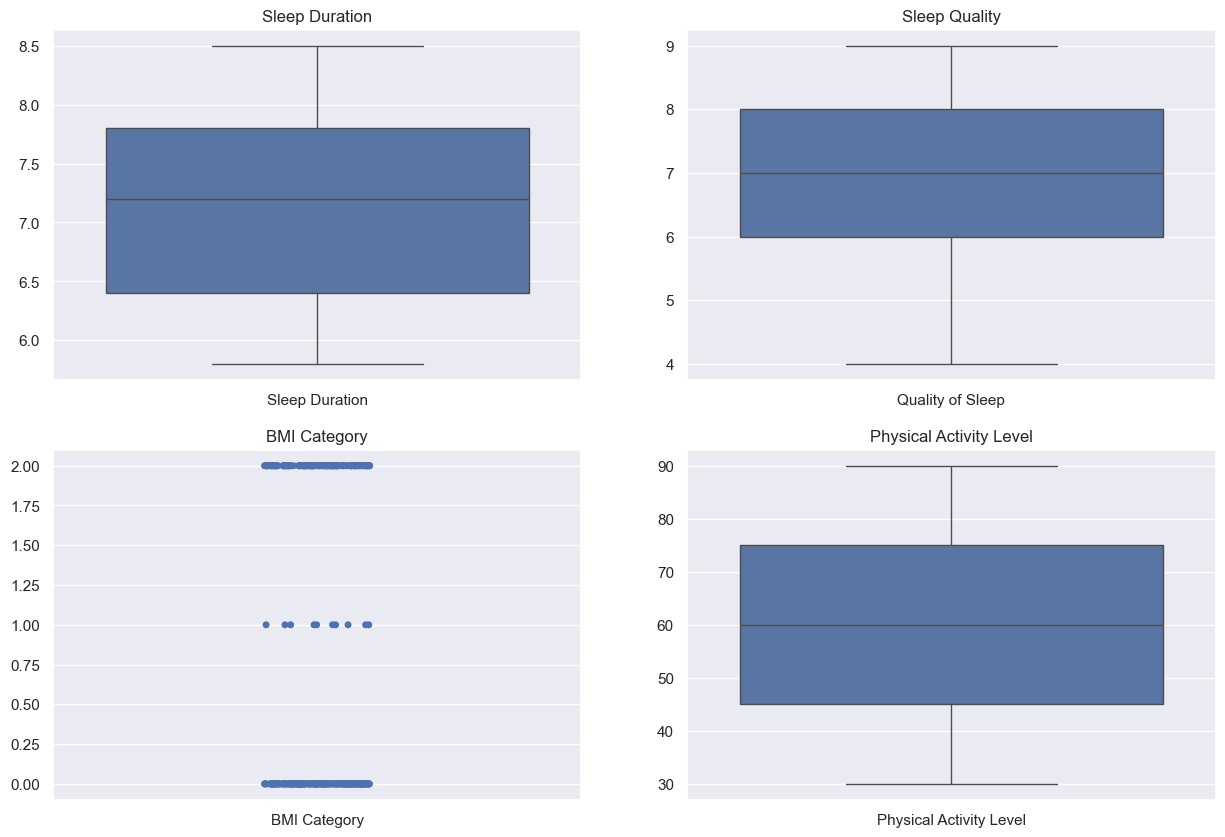

In [349]:
# Initial plotting
fig,axes = plt.subplots(2, 2, figsize=(15,10))
sb.boxplot(data =sleepDuration, ax=axes[0,0])
axes[0, 0].set_title("Sleep Duration")
sb.boxplot(data =sleepQuality, ax=axes[0,1])
axes[0, 1].set_title("Sleep Quality")
sb.stripplot(data =bmiCategory, ax=axes[1,0])
axes[1, 0].set_title("BMI Category")
sb.boxplot(data =physicalActivity, ax=axes[1,1])
axes[1, 1].set_title("Physical Activity Level")


## Boxplot, Stripplot and Violin Plots before removing outliers

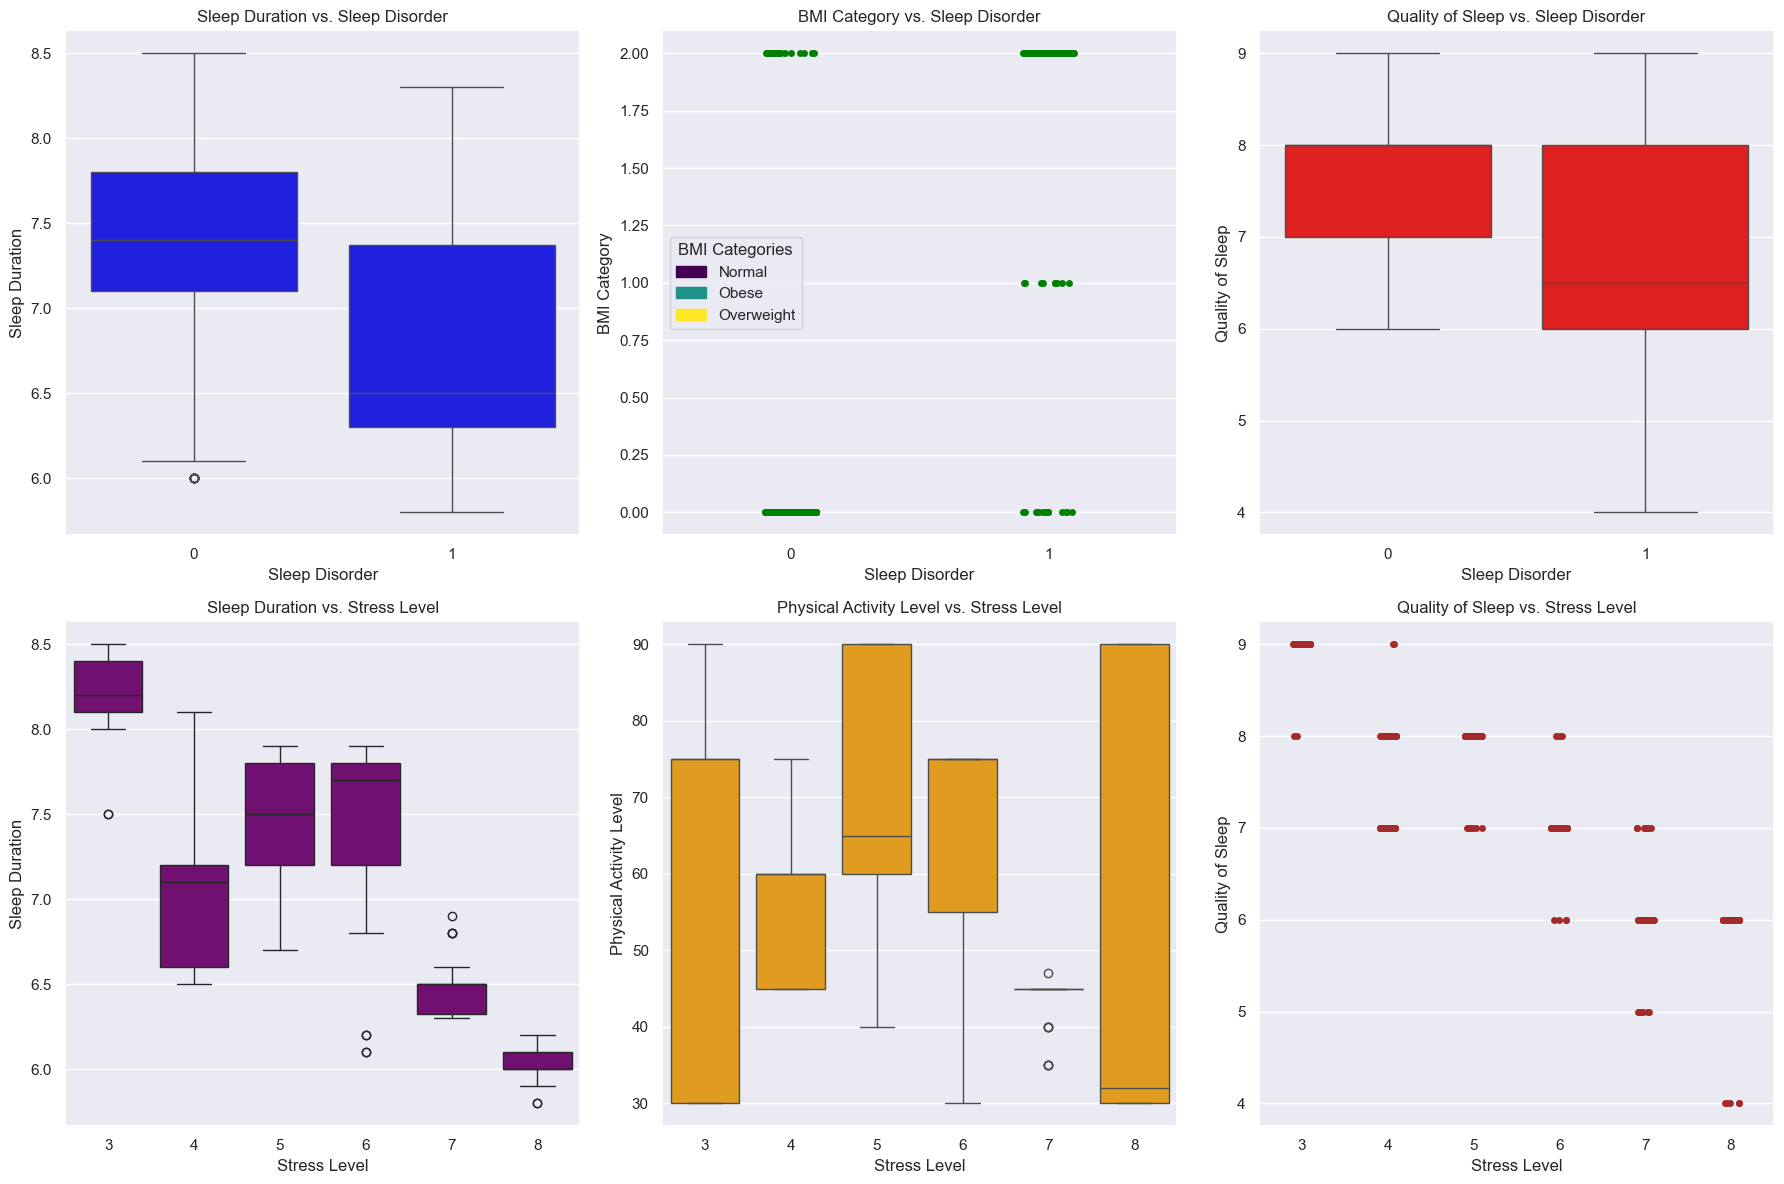

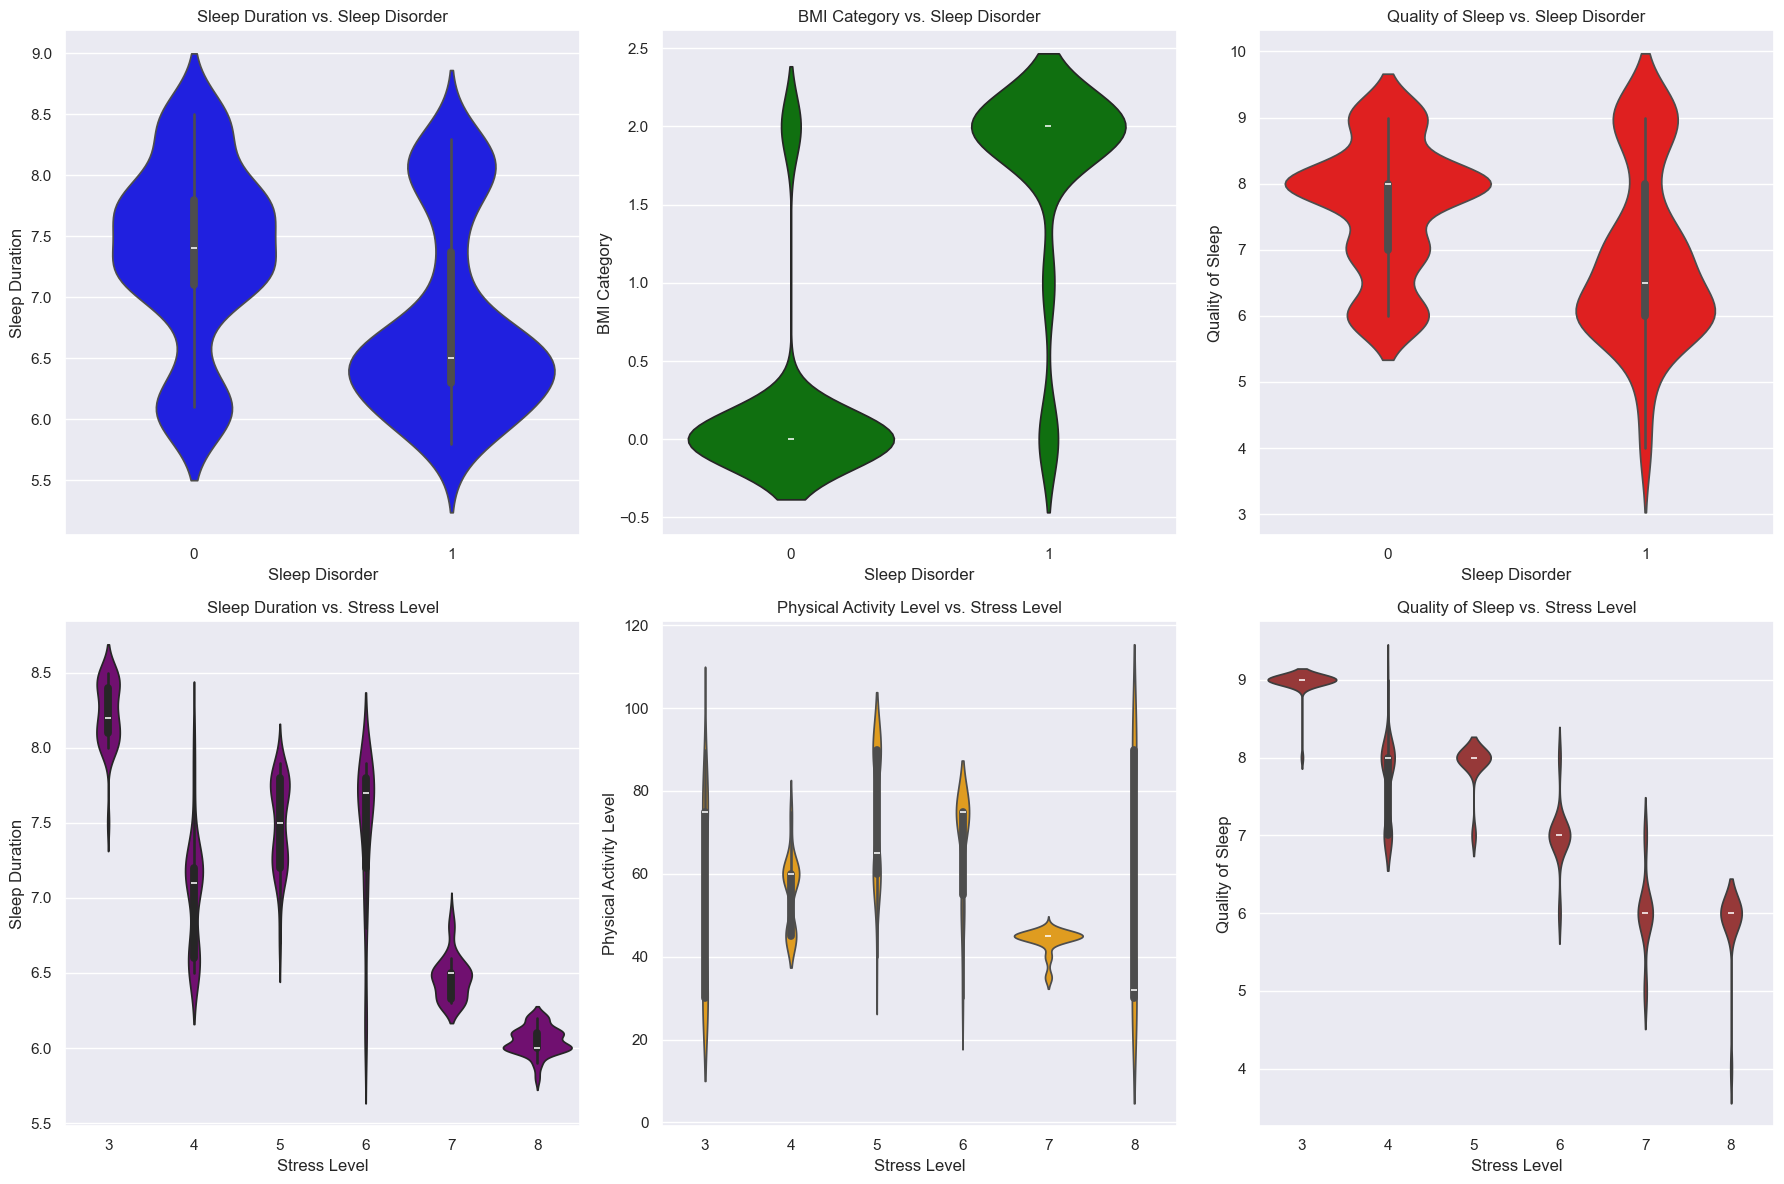

In [350]:
import matplotlib.patches as mpatches

# Create legend: mapping the numeric values to BMI categories
legend_labels = {
    0: "Normal",
    1: "Obese",
    2: "Overweight"
}

# Initial plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plotting graphs related to sleep
sb.boxplot(data=sleepData, y="Sleep Duration", x="Sleep Disorder", ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Sleep Duration vs. Sleep Disorder")

sb.stripplot(data=sleepData, y="BMI Category", x="Sleep Disorder", ax=axes[0, 1], color="green")
axes[0, 1].set_title("BMI Category vs. Sleep Disorder")
patches = [mpatches.Patch(color=plt.cm.viridis(i / max(legend_labels.keys())), label=label) for i, label in legend_labels.items()]
axes[0, 1].legend(handles=patches, title="BMI Categories", loc="best")

sb.boxplot(data=sleepData, y="Quality of Sleep", x="Sleep Disorder", ax=axes[0, 2], color="red")
axes[0, 2].set_title("Quality of Sleep vs. Sleep Disorder")

# Plotting graphs related to stress
sb.boxplot(data=sleepData, y="Sleep Duration", x="Stress Level", ax=axes[1, 0], color="purple")
axes[1, 0].set_title("Sleep Duration vs. Stress Level")

sb.boxplot(data=sleepData, y="Physical Activity Level", x="Stress Level", ax=axes[1, 1], color="orange")
axes[1, 1].set_title("Physical Activity Level vs. Stress Level")

sb.stripplot(data=sleepData, y="Quality of Sleep", x="Stress Level", ax=axes[1, 2], color="brown")
axes[1, 2].set_title("Quality of Sleep vs. Stress Level")

plt.tight_layout()
plt.show()

# Initial plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plotting graphs related to sleep
sb.violinplot(data=sleepData, y="Sleep Duration", x="Sleep Disorder", ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Sleep Duration vs. Sleep Disorder")

sb.violinplot(data=sleepData, y="BMI Category", x="Sleep Disorder", ax=axes[0, 1], color="green")
axes[0, 1].set_title("BMI Category vs. Sleep Disorder")

sb.violinplot(data=sleepData, y="Quality of Sleep", x="Sleep Disorder", ax=axes[0, 2], color="red")
axes[0, 2].set_title("Quality of Sleep vs. Sleep Disorder")

# Plotting graphs related to stress
sb.violinplot(data=sleepData, y="Sleep Duration", x="Stress Level", ax=axes[1, 0], color="purple")
axes[1, 0].set_title("Sleep Duration vs. Stress Level")

sb.violinplot(data=sleepData, y="Physical Activity Level", x="Stress Level", ax=axes[1, 1], color="orange")
axes[1, 1].set_title("Physical Activity Level vs. Stress Level")

sb.violinplot(data=sleepData, y="Quality of Sleep", x="Stress Level", ax=axes[1, 2], color="brown")
axes[1, 2].set_title("Quality of Sleep vs. Stress Level")


plt.tight_layout()
plt.show()


## Boxplot, Stripplot and Violin Plots after removing individual data outliers

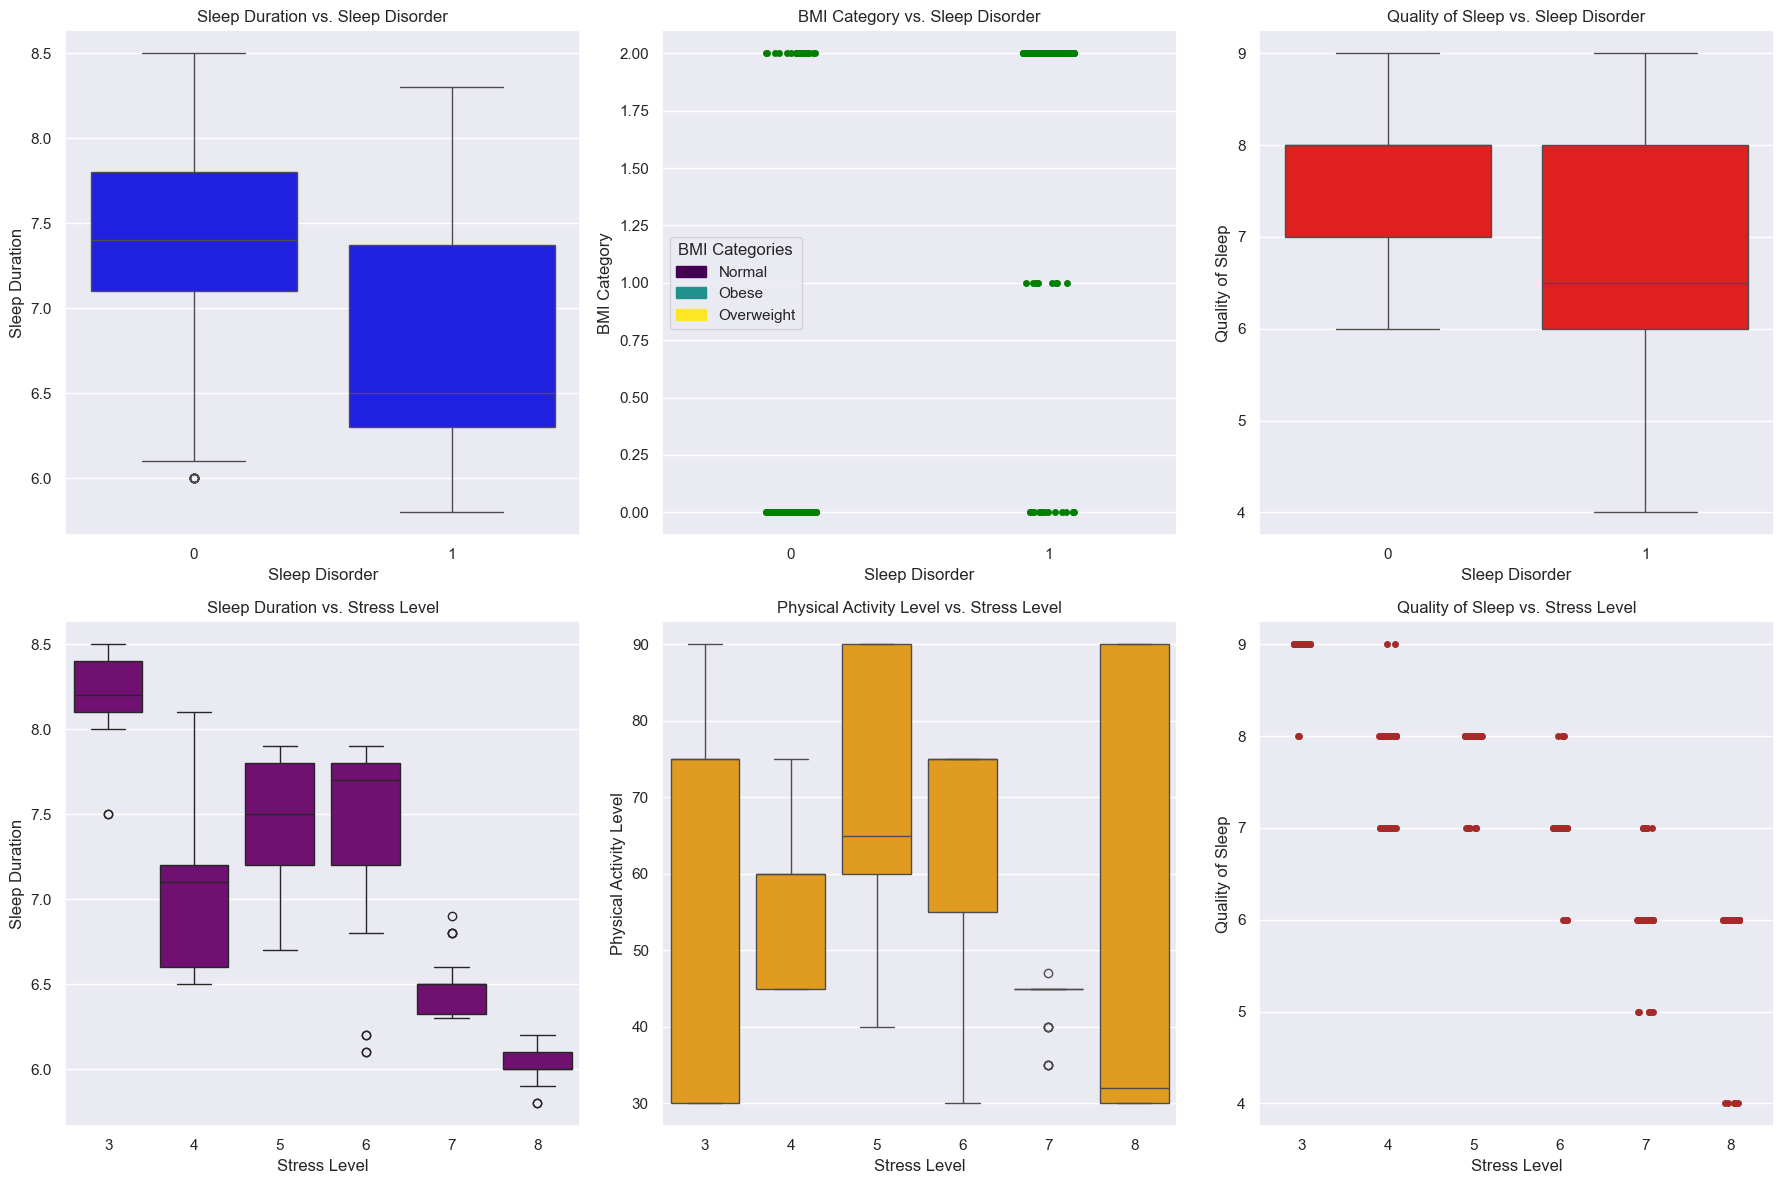

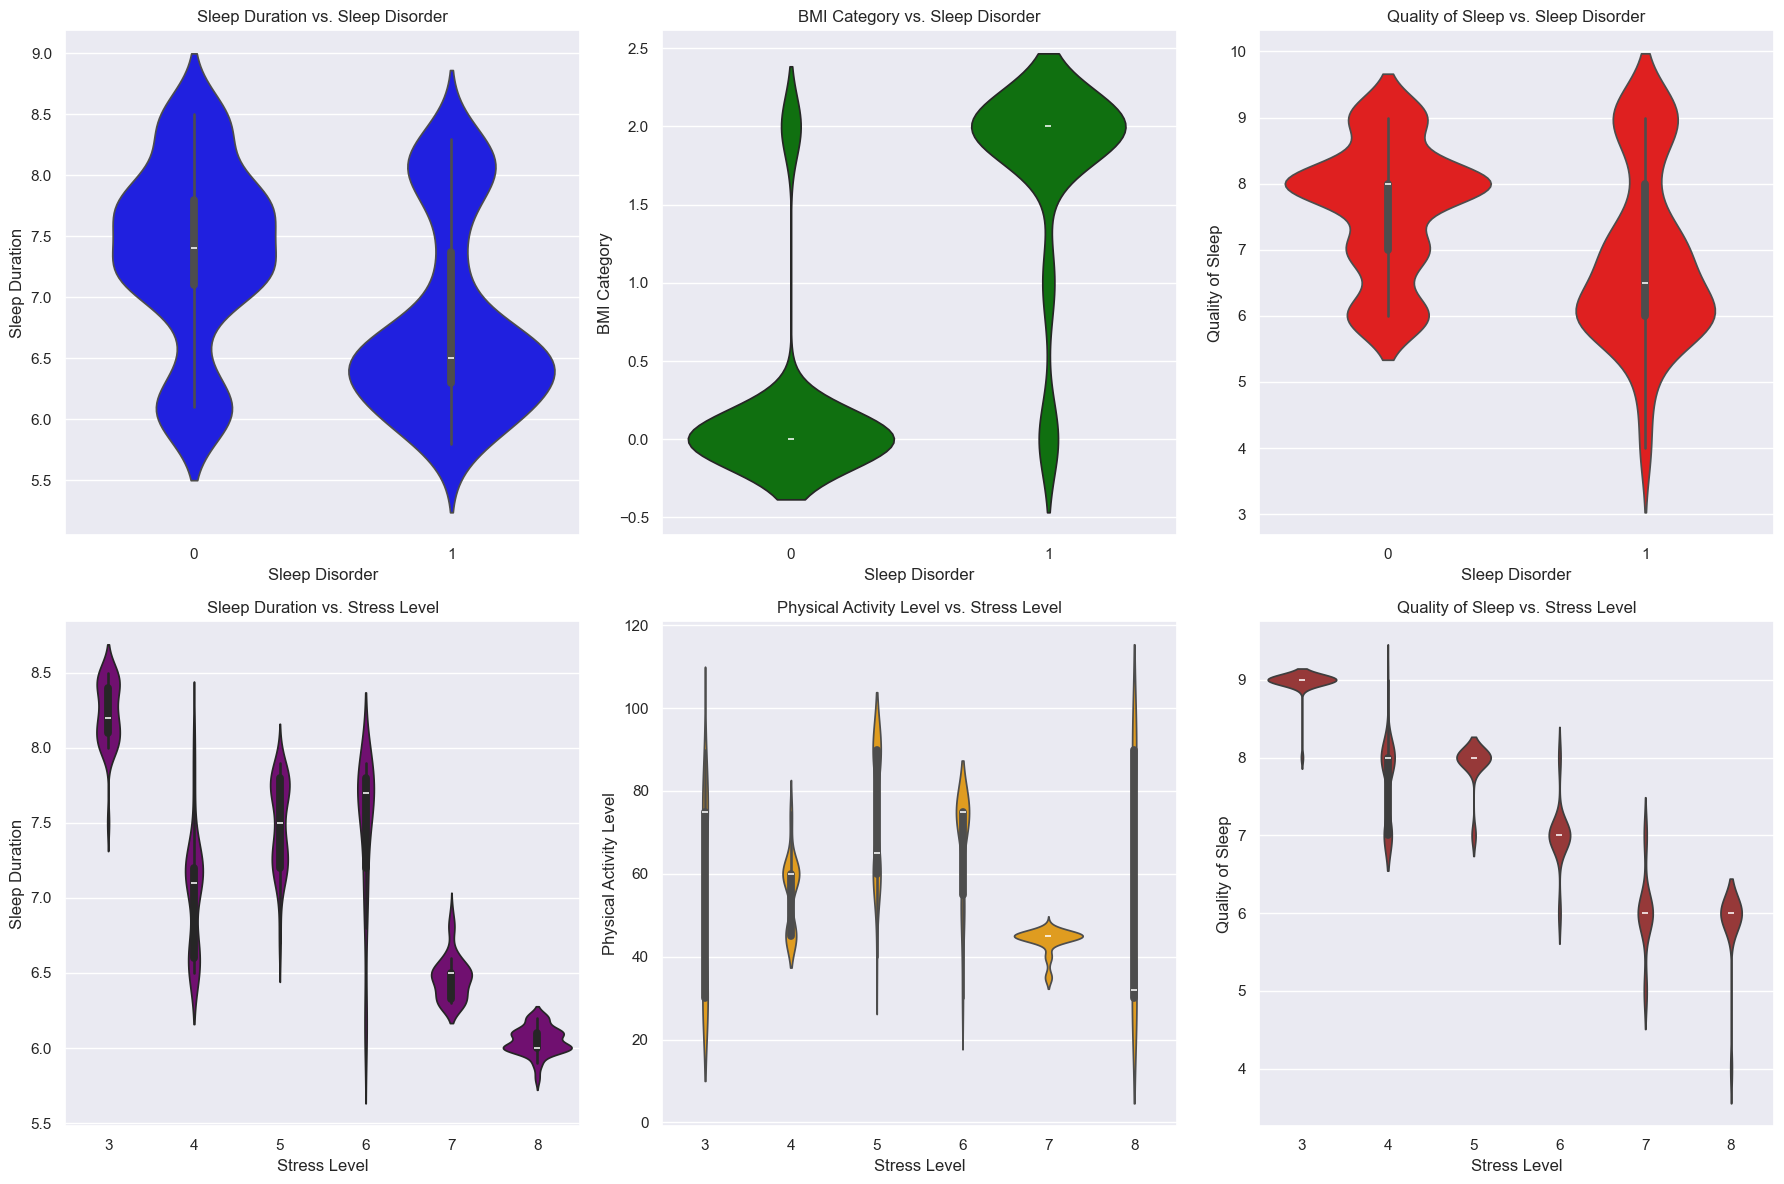

In [351]:
# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Removing outliers for each column
clean_data = remove_outliers(sleepData, "Sleep Duration")
clean_data = remove_outliers(clean_data, "Quality of Sleep")
clean_data = remove_outliers(clean_data, "BMI Category")
clean_data = remove_outliers(clean_data, "Physical Activity Level")
clean_data = remove_outliers(clean_data, "Stress Level")

# Recreating the plots without outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plotting the graphs related to sleep without outliers
sb.boxplot(data=clean_data, y="Sleep Duration", x="Sleep Disorder", ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Sleep Duration vs. Sleep Disorder")

sb.stripplot(data=clean_data, y="BMI Category", x="Sleep Disorder", ax=axes[0, 1], color="green")
axes[0, 1].set_title("BMI Category vs. Sleep Disorder")
axes[0, 1].legend(handles=patches, title="BMI Categories", loc="best")

sb.boxplot(data=clean_data, y="Quality of Sleep", x="Sleep Disorder", ax=axes[0, 2], color="red")
axes[0, 2].set_title("Quality of Sleep vs. Sleep Disorder")

# Plotting graphs related to stress
sb.boxplot(data=clean_data, y="Sleep Duration", x="Stress Level", ax=axes[1, 0], color="purple")
axes[1, 0].set_title("Sleep Duration vs. Stress Level")

sb.boxplot(data=clean_data, y="Physical Activity Level", x="Stress Level", ax=axes[1, 1], color="orange")
axes[1, 1].set_title("Physical Activity Level vs. Stress Level")

sb.stripplot(data=clean_data, y="Quality of Sleep", x="Stress Level", ax=axes[1, 2], color="brown")
axes[1, 2].set_title("Quality of Sleep vs. Stress Level")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plotting the graphs related to sleep without outliers
sb.violinplot(data=clean_data, y="Sleep Duration", x="Sleep Disorder", ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Sleep Duration vs. Sleep Disorder")

sb.violinplot(data=clean_data, y="BMI Category", x="Sleep Disorder", ax=axes[0, 1], color="green")
axes[0, 1].set_title("BMI Category vs. Sleep Disorder")

sb.violinplot(data=clean_data, y="Quality of Sleep", x="Sleep Disorder", ax=axes[0, 2], color="red")
axes[0, 2].set_title("Quality of Sleep vs. Sleep Disorder")

# Plotting graphs related to stress
sb.violinplot(data=clean_data, y="Sleep Duration", x="Stress Level", ax=axes[1, 0], color="purple")
axes[1, 0].set_title("Sleep Duration vs. Stress Level")

sb.violinplot(data=clean_data, y="Physical Activity Level", x="Stress Level", ax=axes[1, 1], color="orange")
axes[1, 1].set_title("Physical Activity Level vs. Stress Level")

sb.violinplot(data=clean_data, y="Quality of Sleep", x="Stress Level", ax=axes[1, 2], color="brown")
axes[1, 2].set_title("Quality of Sleep vs. Stress Level")

plt.tight_layout()
plt.show()

# Sleep Disorder Analysis

## Split dataset into training and test sets

In [352]:
from sklearn.model_selection import train_test_split, cross_val_score

# Combine variables into a single DataFrame
X = pd.concat([sleepDuration, sleepQuality, bmiCategory], axis=1)
y = sleepDisorder.values.ravel()  # Flatten sleepDisorder into a 1D array

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Scaling test sets and training sets

In [353]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Function to display ROC curve for data

In [354]:
from sklearn.metrics import roc_curve, auc

def getRocCurve(y_test, y_pred):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Compute Area Under the ROC Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    ## more right angle the top, better the model

## Function to display confusion matrix

In [355]:
from sklearn.metrics import confusion_matrix
def displayConfusionMatrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(6, 3))
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Use Logistic Regression Model
## Base case model (most simple)

In [356]:
from sklearn.linear_model import LogisticRegression
    
def logisticRegression(X_train, X_test, y_train):
    # Initialize logistic regression model
    log_reg_model = LogisticRegression()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    
    # Fit the logistic regression model to your training data with selected features
    log_reg_model.fit(X_train_scaled, y_train)

    # Predict data
    y_pred_log = log_reg_model.predict(X_test_scaled)

    return y_pred_log

## Use Logistic Regression to predict SleepDisorder
### Predictors: "Quality of Sleep", "Sleep Duration", "BMI Category"

Accuracy: 0.89
Precision: 0.91
Recall: 0.85
F1 Score: 0.88


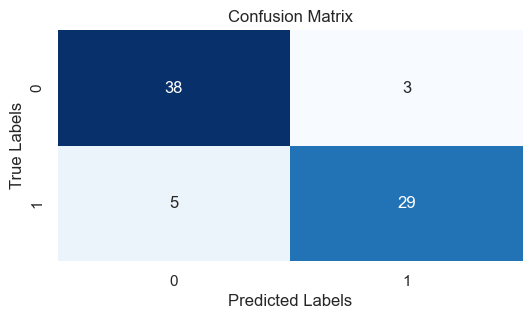

In [357]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred = logisticRegression(X_train, X_test, y_train)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plotting the confusion matrix
displayConfusionMatrix(y_test, y_pred)


## Demonstrate the Logistic Regression model's performance by assessing its ROC AUC (Receiver Operating Characteristic Area Under the Curve).

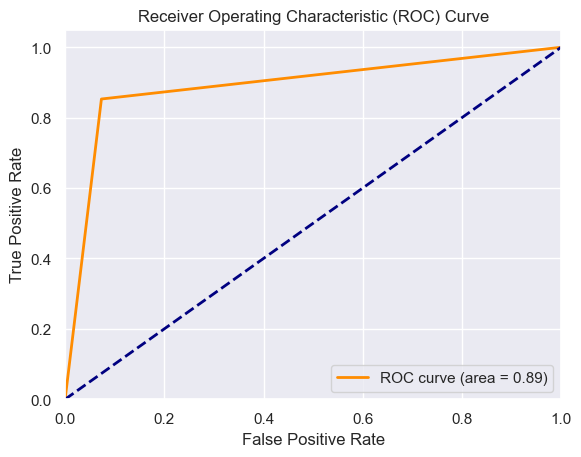

In [358]:
getRocCurve(y_test, y_pred)

# Random Forest Function

In [359]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Function for random tree model

def random_forest_train_evaluate(X_train_scaled, X_test_scaled, y_train, y_test):
    # Initialize model
    random_forest = RandomForestClassifier()
    
    # Train the model   
    random_forest.fit(X_train_scaled, y_train)
    
    # Get feature importances
    feature_importances = random_forest.feature_importances_

    # Evaluate the model that used all features using cross-validation
    random_forest_scores = cross_val_score(random_forest, X_train_scaled, y_train, cv=5)

    # Check model performance
    print("Random Forest Cross-Validation Scores:", random_forest_scores)

    # Make predictions on the testing data
    y_pred = random_forest.predict(X_test_scaled)

    # Evaluate the models on the test data
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)

    return y_pred, feature_importances


## Feature Importance Functions for Random Forest and Gradient Boosting

In [360]:
def displayFeatureImportantRF(predictorData, feature_importances):
    # Create a DataFrame of feature importances
    feature_importance_df = pd.DataFrame({'Feature': predictorData.columns, 'Importance': feature_importances})

    # Sort features by importance (descending order)
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(feature_importance_df)

    # Get feature names and importances from the DataFrame 
    features = feature_importance_df['Feature'].to_numpy()
    importances = feature_importance_df['Importance'].to_numpy()


    # Create a bar chart with this data
    plt.figure(figsize=(8, 4))  # Adjust the figure size as desired
    plt.barh(features, importances, color='skyblue')  # Bar plot with horizontal bars
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance Ranking (Random Forest)')
    plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top

    # Display grid lines and labels
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Show the plot
    plt.tight_layout()
    plt.show()


def displayFeatureImportantGB(predictorData, feature_importances):
    # Sort feature importances in descending order
    sorted_indices = feature_importances.argsort()[::-1]

    # Print feature names and their importances
    for idx in sorted_indices:
        print(f"{predictorData.columns[idx]}: {feature_importances[idx]}")

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

    # Sort feature importances in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(8, 4))
    sb.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()


## Use Random Forest to predict SleepDisorder
### Predictors: "Quality of Sleep", "Sleep Duration", "BMI Category"

### Scale data

In [361]:
# Scale the data
X_train_selected_scaled = scaler.fit_transform(X_train)
X_test_selected_scaled = scaler.transform(X_test)

Random Forest Cross-Validation Scores: [0.93333333 0.83333333 0.93333333 0.94915254 0.89830508]
Accuracy: 0.9333333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        41
           1       0.91      0.94      0.93        34

    accuracy                           0.93        75
   macro avg       0.93      0.93      0.93        75
weighted avg       0.93      0.93      0.93        75



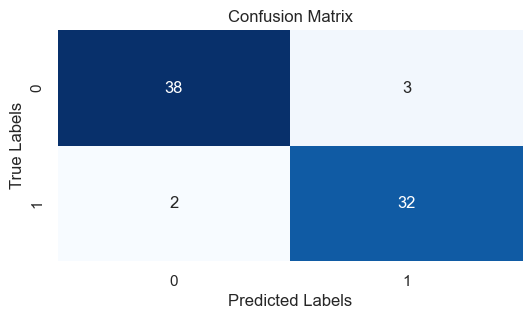

In [362]:
# Put data into function
y_pred, feature_importances = random_forest_train_evaluate(X_train_selected_scaled, X_test_selected_scaled, y_train, y_test)
displayConfusionMatrix(y_test, y_pred)

### Display feature importances for Random Forest when predicting Sleep Disorder

            Feature  Importance
2      BMI Category    0.546458
0    Sleep Duration    0.333664
1  Quality of Sleep    0.119878


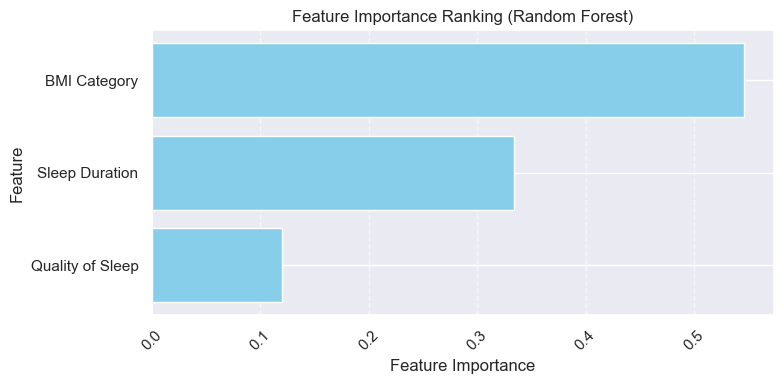

In [363]:
displayFeatureImportantRF(X, feature_importances)

## Demonstrate the Random Forest model's performance by assessing its ROC AUC (Receiver Operating Characteristic Area Under the Curve).

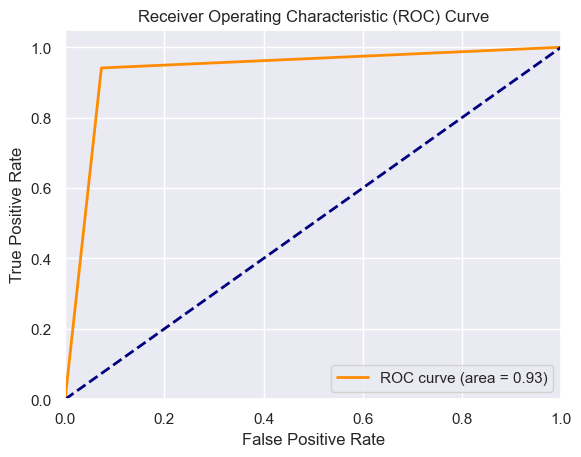

In [364]:
getRocCurve(y_test, y_pred)

# Gradient Boosting Function

In [365]:
from sklearn.ensemble import GradientBoostingClassifier

def gradientBoosting(X_train_scaled, X_test_scaled, y_train, y_test):
    # Assuming X_train, X_test, y_train, y_test are your train-test split data
    # Initialize Gradient Boosting Classifier
    gb_model = GradientBoostingClassifier()
    
    # Fit the model to your training data
    gb_model.fit(X_train_scaled, y_train)
    
    # Get feature importances
    feature_importances = gb_model.feature_importances_
    
    # Make predictions on the test data
    y_pred = gb_model.predict(X_test_scaled)
    
    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification report: ", report)
    return y_pred, feature_importances

## Use Random Forest to predict SleepDisorder
### Predictors: "Quality of Sleep", "Sleep Duration", "BMI Category"

Accuracy: 0.9333333333333333
Classification report:                precision    recall  f1-score   support

           0       0.95      0.93      0.94        41
           1       0.91      0.94      0.93        34

    accuracy                           0.93        75
   macro avg       0.93      0.93      0.93        75
weighted avg       0.93      0.93      0.93        75



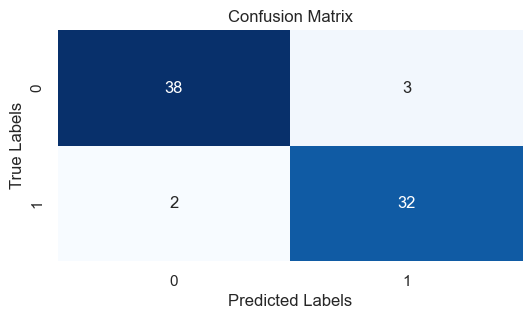

In [366]:
y_pred, feature_importances = gradientBoosting(X_train_selected_scaled, X_test_selected_scaled, y_train, y_test)
displayConfusionMatrix(y_test, y_pred)

### Display feature importances for gradient boosting when predicting Sleep Disorder

BMI Category: 0.8623167163069569
Sleep Duration: 0.08442269873414866
Quality of Sleep: 0.053260584958894484


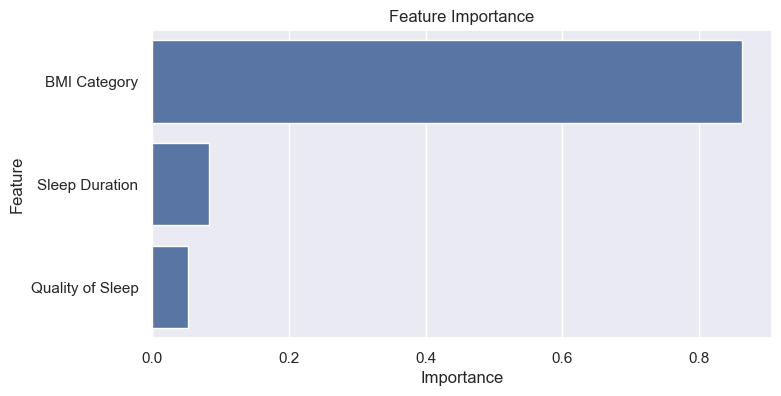

In [367]:
displayFeatureImportantGB(X, feature_importances)

## Demonstrate the Gradient Boosting model's performance by assessing its ROC AUC (Receiver Operating Characteristic Area Under the Curve).

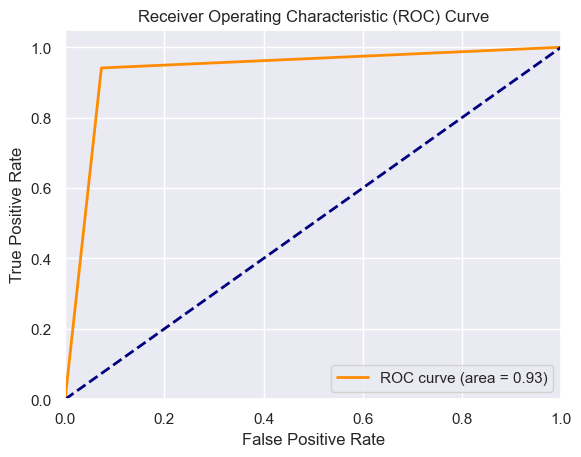

In [368]:
getRocCurve(y_test, y_pred)

# Stress Level Analysis

## Split the data into test and training sets

In [369]:
# Combine variables into a single DataFrame
X = pd.concat([sleepDuration, sleepQuality, physicalActivity], axis=1)

y = stressLevel.values.ravel()  # Flatten sleepDisorder into a 1D array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scaling training and test sets

In [370]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Use Logistic Regression to predict Stress Level
### Predictors: "Quality of Sleep", "Sleep Duration", "Physical Activity Level"

Accuracy: 0.72
Precision: 0.81
Recall: 0.72
F1 Score: 0.71


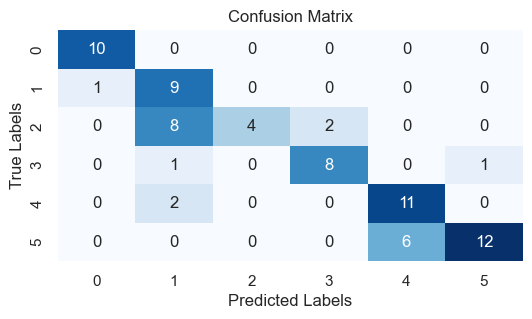

In [371]:
y_pred = logisticRegression(X_train, X_test, y_train)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

displayConfusionMatrix(y_test, y_pred)


# Using Random Forest Model to Predict Stress Level

## Use Random Forest to predict Stress Level
### Predictors: "Quality of Sleep", "Sleep Duration", "Physical Activity Level"

Random Forest Cross-Validation Scores: [0.88333333 0.9        0.9        0.86440678 0.84745763]
Accuracy: 0.9066666666666666
Classification Report:
               precision    recall  f1-score   support

           3       1.00      1.00      1.00        10
           4       0.60      0.90      0.72        10
           5       0.91      0.71      0.80        14
           6       1.00      1.00      1.00        10
           7       1.00      0.85      0.92        13
           8       1.00      1.00      1.00        18

    accuracy                           0.91        75
   macro avg       0.92      0.91      0.91        75
weighted avg       0.93      0.91      0.91        75



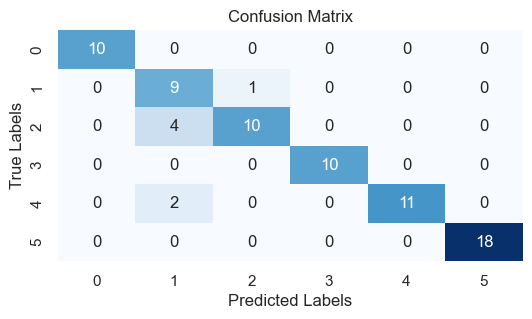

In [372]:
# # Scale the data
X_train_selected_scaled = scaler.fit_transform(X_train)
X_test_selected_scaled = scaler.transform(X_test)

# Put data into function
y_pred, feature_importances = random_forest_train_evaluate(X_train_selected_scaled, X_test_selected_scaled, y_train, y_test)
displayConfusionMatrix(y_test, y_pred)


### Display feature importances for Random Forest when predicting Stress Level

                   Feature  Importance
0           Sleep Duration    0.402809
1         Quality of Sleep    0.325520
2  Physical Activity Level    0.271670


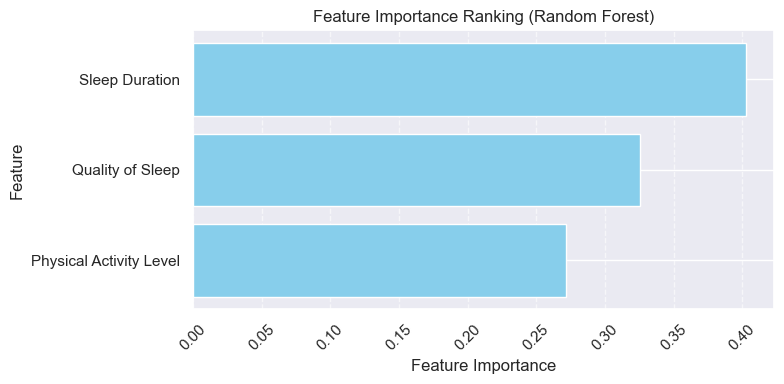

In [373]:
displayFeatureImportantRF(X, feature_importances)

# Using Gradient Boosting to predict Stress Level

## Use Gradient Boosting to predict Stress Level
### Predictors: "Quality of Sleep", "Sleep Duration", "Physical Activity Level"

Accuracy: 0.9066666666666666
Classification report:                precision    recall  f1-score   support

           3       1.00      1.00      1.00        10
           4       0.60      0.90      0.72        10
           5       0.91      0.71      0.80        14
           6       1.00      1.00      1.00        10
           7       1.00      0.85      0.92        13
           8       1.00      1.00      1.00        18

    accuracy                           0.91        75
   macro avg       0.92      0.91      0.91        75
weighted avg       0.93      0.91      0.91        75



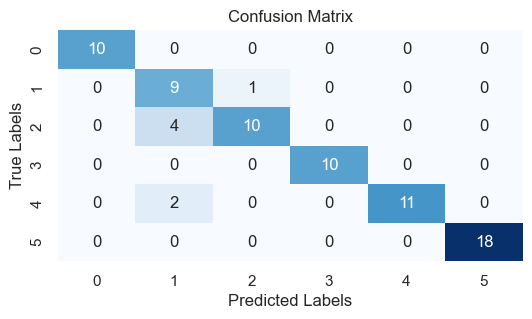

In [374]:
y_pred, feature_importances = gradientBoosting(X_train_selected_scaled, X_test_selected_scaled, y_train, y_test)
displayConfusionMatrix(y_test, y_pred)

### Display feature importances for Gradient Boosting when predicting Stress Level

Sleep Duration: 0.5187451287096773
Quality of Sleep: 0.2738848948962405
Physical Activity Level: 0.20736997639408217


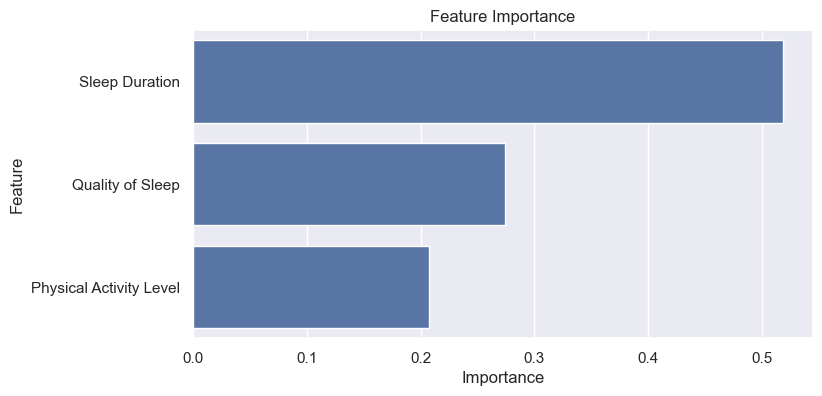

In [375]:
displayFeatureImportantGB(X, feature_importances)